# Item-Item or Product-Product Recommender


If you've used Netflix, Amazon Prime or any online movie streaming service you may have noticed the section "Why did you watch Movie X ... ". This section gives us recommendations of movies we might like based on movies we've already seen.  

In this first part we will develop an item-item recommendation system using [collaborative filtering](https://es.wikipedia.org/wiki/Filtrado_colaborativo).

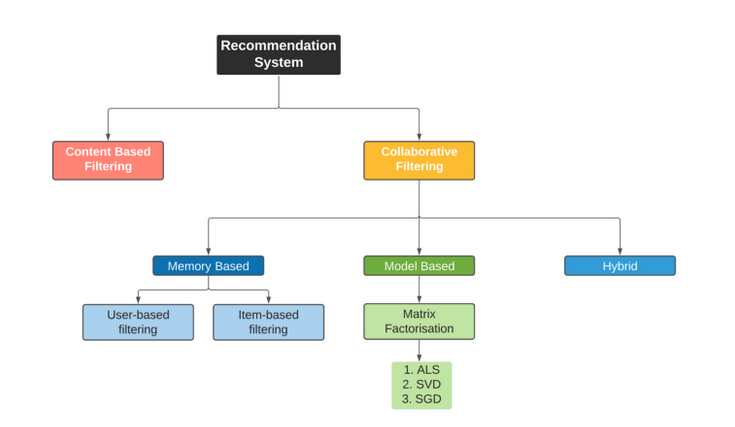

In [112]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import implicit
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(16,6)})

## ETL



Descargar el dataset [MovieLens](https://www.wikiwand.com/en/MovieLens). Se pueden descargar desde un link directo, Amazon o desde github. Son dos bases: **ratings.csv** & **movies.csv**.  
+ **github**:
  - https://raw.githubusercontent.com/IEXE-Tec/mcda-marketing/main/ratings.csv
  - https://raw.githubusercontent.com/IEXE-Tec/mcda-marketing/main/movies.csv
+ **amazon**:
  - https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv
  - https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv

In [113]:
ratings = pd.read_csv("https://raw.githubusercontent.com/IEXE-Tec/mcda-marketing/main/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [114]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [115]:
movies = pd.read_csv("https://raw.githubusercontent.com/IEXE-Tec/mcda-marketing/main/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [116]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


## EDA (Exploratory Data Analysis)

### Variables

For this first part of the project we will use the `Ratings` of the users. Let's explore the particularities of each variable.

In [117]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Numero de ratings: {n_ratings}")
print(f"Numero de movieId's unicos: {n_movies}")
print(f"Numero de usuarios unicos: {n_users}")
print(f"Numero promedio de ratings generados por usuario: {round(n_ratings/n_users, 2)}")
print(f"Numero promedio de ratings por pelicula: {round(n_ratings/n_movies, 2)}")

Numero de ratings: 100836
Numero de movieId's unicos: 9724
Numero de usuarios unicos: 610
Numero promedio de ratings generados por usuario: 165.3
Numero promedio de ratings por pelicula: 10.37


Now let's analyze the behavior per user

In [118]:
user_freq = ratings[['userId', 'movieId']].groupby('userId').count().reset_index()
user_freq.columns = ['userId', 'n_ratings']
user_freq.head()

,userId,n_ratings
0,1,232
1,2,29
2,3,39
3,4,216
4,5,44


In [119]:
user_freq.describe()

,userId,n_ratings
count,610.000000,610.000000
mean,305.500000,165.304918
std,176.236111,269.480584
min,1.000000,20.000000
25%,153.250000,35.000000
50%,305.500000,70.500000
75%,457.750000,168.000000
max,610.000000,2698.000000


+ On **average** each user has rated 165 movies, this is good news.  
+ We have an **average** of 70, well below average, which means that our distribution has long queues.
+ The user who has rated the least number of movies is 20, which is not bad at all.  

In [120]:
ratings['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

We can see that our users are what is called optimistic. Let's look at the 25th percentile, from this we can deduce that at least 75% of the ratings are greater than or equal to 3.

Let us now analyze the distributions

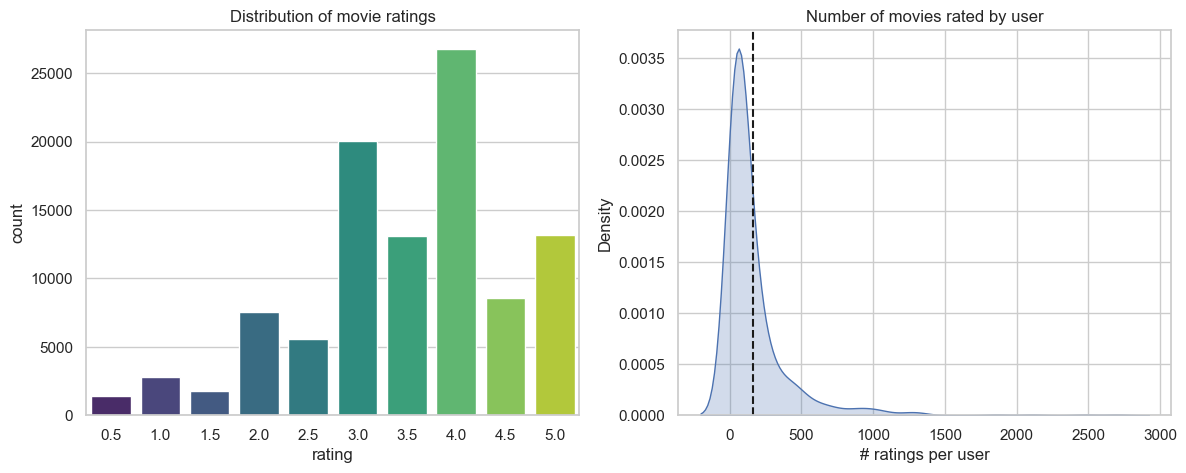

In [121]:
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings")

plt.subplot(1,2,2)
ax = sns.kdeplot(user_freq['n_ratings'], shade=True, legend=False)
plt.axvline(user_freq['n_ratings'].mean(), color="k", linestyle="--")
plt.xlabel("# ratings per user")
plt.ylabel("Density")
plt.title("Number of movies rated by user")
plt.show()

We can see that our ratings are skewed to the left and it seems that people are quite optimistic.

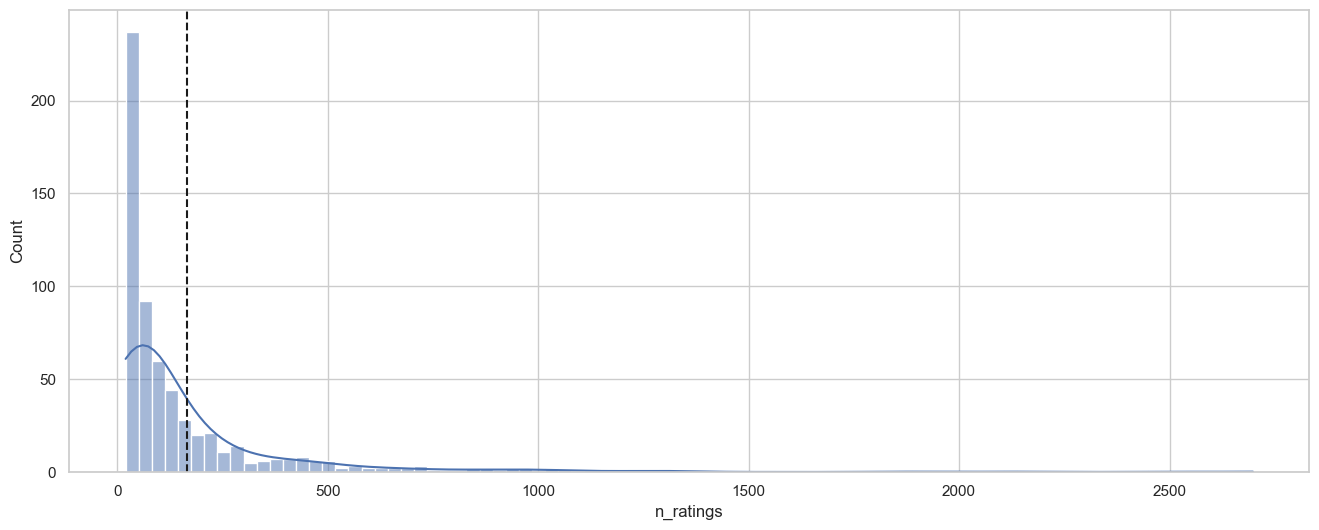

In [122]:
sns.histplot(data=user_freq, x='n_ratings', kde=True)
plt.axvline(user_freq['n_ratings'].mean(), color="k", linestyle="--")

### Which movies have the most extreme ratings?

In [123]:
ratings.head(2)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247


In [124]:
mean_rating = ratings.groupby('movieId')[['rating']].mean()

lowest_rated = mean_rating['rating'].idxmin()
movies.loc[movies['movieId'] == lowest_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


In [125]:
mean_rating.head(2)

,rating
movieId,
1,3.920930
2,3.431818


In [126]:
lowest_rated

3604

In [127]:
highest_rated = mean_rating['rating'].idxmax()
movies.loc[movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


In [128]:
highest_rated

53

Lamerica is the highest rated movie, but how many ratings does it have?

In [129]:
ratings[ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


We can see that Lamerica has only two ratings, which raises the problem of having small samples. Recall that small samples tend to have extreme results either high or low.

### Distribution of Ratings

In [130]:
ratings_per_movie = ratings.groupby('movieId', as_index=False).agg({'rating':['count', 'mean', 'std']})
ratings_per_movie.columns = ['movieId', 'n_ratings', 'mean_ratings', 'std_ratings']
ratings_per_movie.head()

,movieId,n_ratings,mean_ratings,std_ratings
0,1,215,3.920930,0.834859
1,2,110,3.431818,0.881713
2,3,52,3.259615,1.054823
3,4,7,2.357143,0.852168
4,5,49,3.071429,0.907148


<Axes: xlabel='n_ratings', ylabel='mean_ratings'>

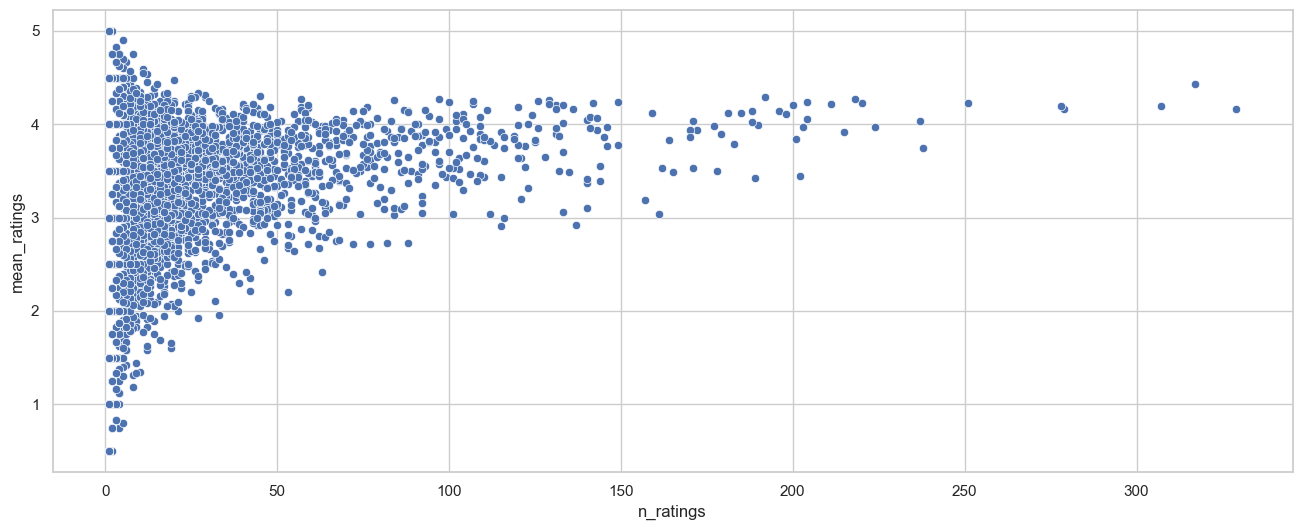

In [131]:
sns.scatterplot(data=ratings_per_movie, x='n_ratings', y='mean_ratings')

<Axes: xlabel='n_ratings', ylabel='std_ratings'>

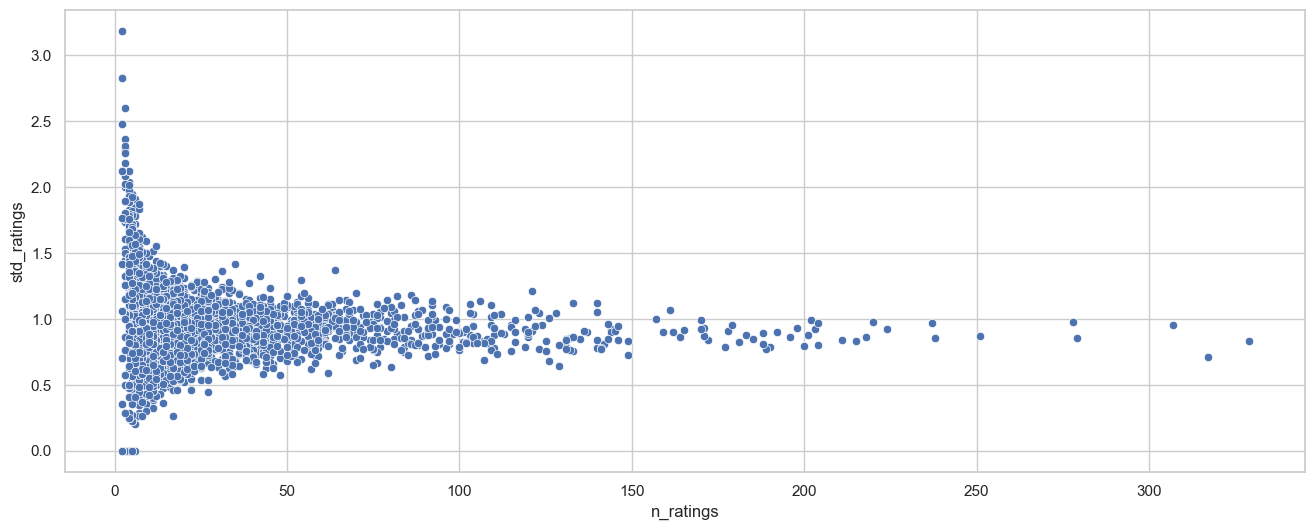

In [132]:
sns.scatterplot(data=ratings_per_movie, x='n_ratings', y='std_ratings')

We can observe that the lower the number of grades the greater the variance, the more grades the lower the average variance. This corresponds to the hypothesis that there is more variance with fewer ratings.  
We can see the movies with few ratings as **outliers**. We really don't want them to bias our analysis, so we have to take measures.

To control for this phenomenon and make our model more robust we can use the **Bayesian Average**. [Bayesian average](https://en.wikipedia.org/wiki/Bayesian_average).

### Bayesian Average




The Bayesian mean is defined as:

$r_{i} = \frac{C \times m + \ \Sigma{ \ \text{reviews}}}{C+N}$  

+ $C:=$ represents how much we value our initial value or confidence. How much we value our beliefs?
+ $m:=$ represents our prior. What do we believe is the real value?
+ $N:=$ is the total number of reviews for the movie $i$.  


For our models we suggest that $m$ is the mean of our sample (`ratings['rating'].mean()`). By the choice of our prior, $C$ represents "the number of observations in our dataset". Then $C$ can be the average number of ratings per movie, i.e., how many ratings on average a movie has.  

We can understand the Bayesian average as a weighted average, where the weighting factor is given by the average number of reviews in all the movies $C$, while the other weighting is given by the reviews of the movie we are analyzing $N$.    

$r_{i} = \frac{C \times m }{C+N} + \frac{\Sigma{ \ \text{reviews}}}{C+N}$  
  
$r_{i} = \frac{C}{C+N}\times m + \frac{N}{C+N}\times \mu_{reviews}$


In [133]:
movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()
movie_stats.head(2)

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818


In [134]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')
movie_stats.head(2)

,movieId,count,mean,bayesian_avg
0,1,215,3.920930,3.890632
1,2,110,3.431818,3.417227


In [135]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
# Difference between true mean and Bayesian mean
movie_stats['diff'] = movie_stats['mean'] - movie_stats['bayesian_avg'] 
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title,diff
277,318,317,4.429022,4.392070,"Shawshank Redemption, The (1994)",0.036953
659,858,192,4.289062,4.236457,"Godfather, The (1972)",0.052606
2224,2959,218,4.272936,4.227052,Fight Club (1999),0.045884
224,260,251,4.231076,4.192646,Star Wars: Episode IV - A New Hope (1977),0.038430
46,50,204,4.237745,4.190567,"Usual Suspects, The (1995)",0.047178


<Axes: xlabel='mean', ylabel='bayesian_avg'>

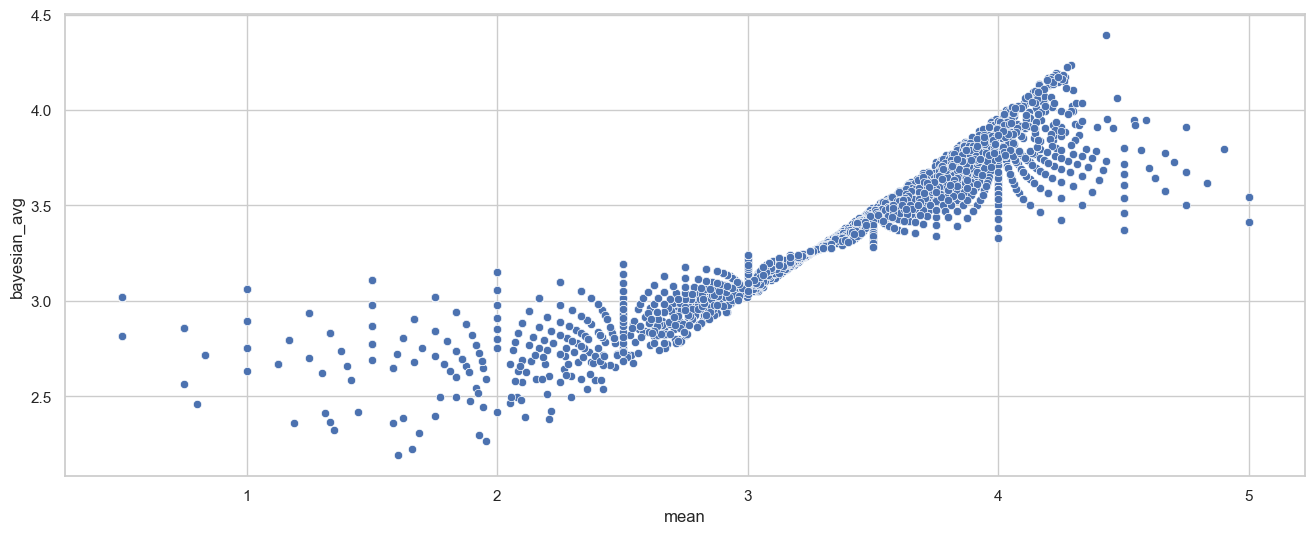

In [136]:
sns.scatterplot(data=movie_stats, x='mean', y='bayesian_avg')

We can observe that the relationship between the two is almost linear, but it is distorted in movies with very high or low ratings. This is because extreme ratings, whether high or low, are related to a low number of observations.

<Axes: xlabel='count', ylabel='diff'>

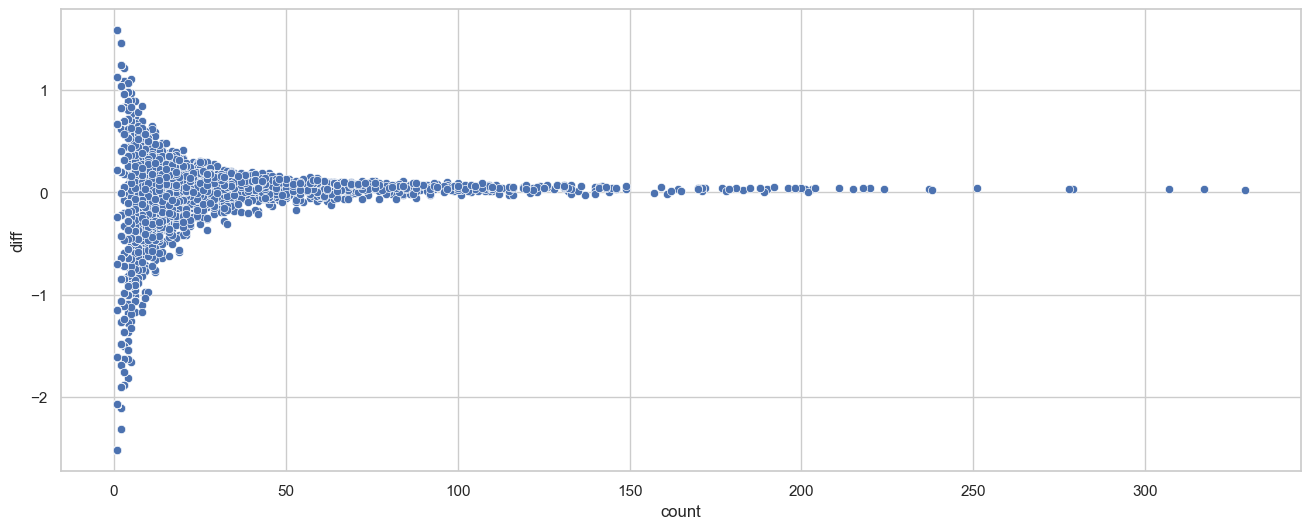

In [137]:
sns.scatterplot(data=movie_stats, x='count', y='diff')

We can observe how the difference between the mean ratings and the Bayesian mean tends to zero the more reviews you have, while the difference is larger for movies that have few ratings.

Using Bayesian averaging, we can see that `Shawshank Redemption`, `The Godfather`, and `Fight Club` are the movies with the best ratings. 

In [138]:
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title,diff
277,318,317,4.429022,4.392070,"Shawshank Redemption, The (1994)",0.036953
659,858,192,4.289062,4.236457,"Godfather, The (1972)",0.052606
2224,2959,218,4.272936,4.227052,Fight Club (1999),0.045884
224,260,251,4.231076,4.192646,Star Wars: Episode IV - A New Hope (1977),0.038430
46,50,204,4.237745,4.190567,"Usual Suspects, The (1995)",0.047178


In [139]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title,diff
1172,1556,19,1.605263,2.190377,Speed 2: Cruise Control (1997),-0.585114
2679,3593,19,1.657895,2.224426,Battlefield Earth (2000),-0.566531
1372,1882,33,1.954545,2.267268,Godzilla (1998),-0.312722
1144,1499,27,1.925926,2.296800,Anaconda (1997),-0.370874
1988,2643,16,1.687500,2.306841,Superman IV: The Quest for Peace (1987),-0.619341


The worst movies are  `Speed 2: Cruise Control`, `Battlefield Earth`, and `Godzilla`.

When modeling you could use our Bayesian Mean, our rating as is or a normalized version. Ideally we should be able to do A/B testing to determine which is the best metric.

## Modeling



Now we will apply the collaborative filtering technique [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) to generate recommendations to users. The assumption of why this filter works is called **"homophily "**. The idea is that users like similar things.  
  
Collaborative filtering is an unsupervised technique that attempts to make recommendations or predictions about people's interests by modeling the tastes of the general population. For example, if almost all the people who liked `GATTACA` liked `John Wick`, i.e. rated it with high values, our model will recommend `John Wick` to the people who liked `GATTACA` and vice versa.  

Remember that this filter is **item-item** so we are looking for similarities in the movies, not between users!

### Create user-item-matrix

The first step is to create `user-item matrix` - or `utility` matrix. In this matrix, the rows represent users, and the columns represent `items`. The beauty is that it is entirely based on ratings, we don't really have any more information about the genre, type, length, etc. of the movies. We only have ratings.


<img src="https://github.com/topspinj/recommender-tutorial/blob/master/images/user-movie-matrix.png?raw=1" width="500px" align="left">

The `create_X()` function returns a sparse scipy array with 4 dictionaries.
- **user_mapper:** user id -> user index 
- **movie_mapper:** movie id -> movie index 
- **user_inv_mapper:** user_index -> user_id
- **movie_inv_mapper:** movie id -> movie index  
  
We need these dictionaries because they will tell us which row and column of the `utility-matrix` corresponds to the user and the movie. This data structure is used in order to save memory, because if we have 30 thousand movies and 1 million users it is easy to fill it. And pointless, because most of the entries are empty.   

**Note:** In the specific case of the implementation the first index corresponds to the movie, and the second to the user. This in order to make easier the abstraction of the distance calculation.

 **X** (user-item) matrix is of type [scipy.sparse.csr_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html).

In [140]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    N = df['userId'].nunique()
    M = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))
    
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [141]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

In [142]:
movie_mapper[1]

0

In [143]:
M = ratings['movieId'].nunique()
M

9724

In [144]:
len(np.unique(ratings["userId"]))

610

In [145]:
len(dict(zip(list(range(M)), np.unique(ratings["movieId"]))))

9724

In [146]:
ratings['movieId'].nunique()

9724

Let's measure sparsity or how sparse our X matrix is.

Let us calculate the quotient of the number of elements that are not empty by the number of total elements. 

$$S=\frac{\text{Number of elements not empty}}{\text{Number of total elements}}$$

In [147]:
X.shape

(9724, 610)

Given the structure of `csr_matrix` the empty elements are filled as zeros, although they are not really zeros but empty. But since we are going to obtain distances it is convenient to put them as zeros.

In [148]:
sparsity = X.count_nonzero()/(X.shape[0]*X.shape[1])

print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.7%


Only 1.7% of the cells are filled. But, a good rule of thumb to implement these models is to have an index greater than 0.5%.

### Write to Disk from X  

If we wish to save our sparse matrix X for later exercises we could do it with the following command (remember that being in Colab this will be saved in our virtual machine and not directly to the drive).  

Documentation: [scipy.sparse.save_npz](https://docs.scipy.org/doc/scipy-1.1.0/reference/generated/scipy.sparse.load_npz.html) 

In [149]:
#from scipy.sparse import save_npz

#save_npz('user_item_matrix.npz', X)

### Normalizations of X

Let's get the average rating per movie. Remember that by converting X to a sparse matrix the missings (not grades) became zeros, so we can't apply the `.mean()` method. We need to add, and divide by the number of actual ratings.

In [150]:
n_ratings_per_movie = X.getnnz(axis=1)
sum_ratings_per_movie = X.sum(axis=1)
n_ratings_per_movie = np.reshape(n_ratings_per_movie, (n_ratings_per_movie.shape[0],1))
print(n_ratings_per_movie.shape)
print(sum_ratings_per_movie.shape)
mean_rating_per_movie = sum_ratings_per_movie/n_ratings_per_movie
# Copiemos a columnas
X_mean_movie = np.tile(mean_rating_per_movie, (1, X.shape[1]))
print(X_mean_movie.shape)

(9724, 1)
(9724, 1)
(9724, 610)


In [151]:
X.getnnz(axis=1)

array([215, 110,  52, ...,   1,   1,   1])

In [152]:
X.sum(axis=1)

matrix([[843. ],
        [377.5],
        [169.5],
        ...,
        [  3.5],
        [  3.5],
        [  4. ]])

In [153]:
print(X_mean_movie[:,0])
print('--------------------')
print(X_mean_movie[:,569])

[[3.92093023]
 [3.43181818]
 [3.25961538]
 ...
 [3.5       ]
 [3.5       ]
 [4.        ]]
--------------------
[[3.92093023]
 [3.43181818]
 [3.25961538]
 ...
 [3.5       ]
 [3.5       ]
 [4.        ]]


`X_mean_movie` is a matrix with shape (9724, 610). The rows represent the average rating of the movies. Each column has the same values, which are the average rating per movie.

In [154]:
X_norm = X - csr_matrix(X_mean_movie)
X_norm.shape

(9724, 610)

In [155]:
#print(X_norm[:,0])
print('---------------')
print(X_norm[:,522])

---------------
  (0, 0)	-3.9209302325581397
  (1, 0)	1.0681818181818183
  (2, 0)	-3.2596153846153846
  (3, 0)	-2.357142857142857
  (4, 0)	-3.0714285714285716
  (5, 0)	-3.946078431372549
  (6, 0)	-3.185185185185185
  (7, 0)	-2.875
  (8, 0)	-3.125
  (9, 0)	-3.496212121212121
  (10, 0)	-3.6714285714285713
  (11, 0)	-2.4210526315789473
  (12, 0)	-3.125
  (13, 0)	-3.8333333333333335
  (14, 0)	-3.0
  (15, 0)	-3.926829268292683
  (16, 0)	-3.7761194029850746
  (17, 0)	-3.7
  (18, 0)	-2.727272727272727
  (19, 0)	-2.5
  (20, 0)	-3.49438202247191
  (21, 0)	-3.2222222222222223
  (22, 0)	-3.125
  (23, 0)	-3.125
  (24, 0)	-3.625
  :	:
  (9699, 0)	-4.5
  (9700, 0)	-2.5
  (9701, 0)	-3.0
  (9702, 0)	-3.75
  (9703, 0)	-2.5
  (9704, 0)	-1.0
  (9705, 0)	-2.5
  (9706, 0)	-3.5
  (9707, 0)	-1.5
  (9708, 0)	-4.0
  (9709, 0)	-1.0
  (9710, 0)	-1.5
  (9711, 0)	-1.0
  (9712, 0)	-1.0
  (9713, 0)	-4.5
  (9714, 0)	-3.5
  (9715, 0)	-3.0
  (9716, 0)	-4.0
  (9717, 0)	-4.0
  (9718, 0)	-3.5
  (9719, 0)	-4.0
  (9720, 0)	

The `X_norm` rows contain the ratings of each user for each movie, minus the average movie rating. This normalization is different from the Bayesian normalization.

## Recommendation with nearest K-neighbors

<img src="https://github.com/topspinj/recommender-tutorial/blob/master/images/knn.png?raw=1" width="20%" align="right"/> 

The idea of using the utility and nearest neighbor matrix is to find which movies are at the shortest distance. And select the $k$ closest as a recommendation. There are different types of distances:

1. Cosine similarity
2. Euclidean distance
3. Manhattan distance
4. Pearson correlation 



`find_similar_movies()` takes the `movieId` and the `user-item` of the matrix X, and return the list of $k$ movies closest to you.

We have to create another dictionary that goes from `movieId` to `title` to interpret our results.

In [156]:
# Diccionario id pelicula -> titulo de pelicula
movie_titles = dict(zip(movies['movieId'], movies['title']))
for i in range(5):
    print(movie_titles[i+1])

Toy Story (1995)
Jumanji (1995)
Grumpier Old Men (1995)
Waiting to Exhale (1995)
Father of the Bride Part II (1995)


The documentation to the method can be found at:  
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html 

In [157]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, k, metric='cosine', show_distance=False):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Returns:
        list of k similar movie ID's
    """
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    k+=1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="auto", metric=metric, n_jobs=-1)
    kNN.fit(X)
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # We only calculate the distance using the ratings of people who watched the movie.   
    # If the users did not watch the movie then we ignore them.
    neighbour = kNN.kneighbors(movie_vec, return_distance=show_distance)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [158]:
print(movie_mapper[10])
print(X[movie_mapper[10]])

9
  (0, 5)	3.0
  (0, 7)	2.0
  (0, 10)	3.0
  (0, 18)	2.0
  (0, 20)	5.0
  (0, 25)	3.0
  (0, 30)	4.0
  (0, 33)	5.0
  (0, 41)	5.0
  (0, 42)	4.0
  (0, 45)	3.0
  (0, 55)	4.0
  (0, 56)	3.0
  (0, 58)	3.0
  (0, 62)	3.0
  (0, 67)	4.5
  (0, 80)	1.0
  (0, 81)	3.5
  (0, 83)	3.0
  (0, 90)	3.5
  (0, 92)	4.0
  (0, 93)	3.0
  (0, 98)	4.0
  (0, 103)	3.0
  (0, 116)	3.0
  :	:
  (0, 497)	3.0
  (0, 500)	4.0
  (0, 516)	0.5
  (0, 519)	4.0
  (0, 521)	4.5
  (0, 523)	4.0
  (0, 530)	4.0
  (0, 533)	4.0
  (0, 540)	4.0
  (0, 556)	4.5
  (0, 558)	3.0
  (0, 565)	3.0
  (0, 568)	4.0
  (0, 569)	3.5
  (0, 572)	4.5
  (0, 579)	3.5
  (0, 583)	5.0
  (0, 587)	3.0
  (0, 589)	3.5
  (0, 591)	3.0
  (0, 596)	3.0
  (0, 598)	3.5
  (0, 601)	3.0
  (0, 607)	4.0
  (0, 608)	4.0


### X

In [159]:
movie_id = 1

similar_ids = find_similar_movies(movie_id, X, k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title} we recommend checking out some similar titles: ")
for i in similar_ids:
    print(movie_titles[i])

Because you watched Toy Story (1995) we recommend checking out some similar titles: 
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)
Back to the Future (1985)


In [160]:
movie_id = 1
similar_ids = find_similar_movies(movie_id, X, k=10, metric="euclidean")

movie_title = movie_titles[movie_id]
print(f"Because you watched {movie_title} we recommend checking out some similar titles: ")
for i in similar_ids:
    print(movie_titles[i])

Because you watched Toy Story (1995) we recommend checking out some similar titles: 
Toy Story 2 (1999)
Mission: Impossible (1996)
Independence Day (a.k.a. ID4) (1996)
Bug's Life, A (1998)
Nutty Professor, The (1996)
Willy Wonka & the Chocolate Factory (1971)
Babe (1995)
Groundhog Day (1993)
Mask, The (1994)
Honey, I Shrunk the Kids (1989)


Note that in this case we do not use any normalization, and use the raw rating.

### X_norm

In [161]:
movie_id = 1
similar_ids = find_similar_movies(movie_id, X_norm, k=10)

movie_title = movie_titles[movie_id]
print(f"Because you watched {movie_title} we recommend checking out some similar titles: ")

for i in similar_ids:
    print(movie_titles[i])

Because you watched Toy Story (1995) we recommend checking out some similar titles: 
Toy Story 2 (1999)
Toy Story 3 (2010)
Honey, I Shrunk the Kids (1989)
Nutty Professor, The (1996)
Bug's Life, A (1998)
Bambi (1942)
Pinocchio (1940)
Jungle Book, The (1967)
Space Jam (1996)
James and the Giant Peach (1996)


### Evaluation

The evaluation of an offline item-item collaborative filtering system is not really robust because it uses the same data it was built with, so the evaluation metrics are very difficult to implement.  
We could evaluate it with A/B testing, for example.  

Here is a paper on the subject: https://arxiv.org/pdf/1506.04135.pdf 

One way to evaluate how good the recommendation of a specific m1 movie is would be to see if the rest of the recommended movies also recommend m1. Although this is still a very weak evaluation criterion.

We could also eliminate some movies seen by users, estimate our model and see if our recommender recommended the eliminated movies with high ratings and did not recommend the movies with low ratings. However, like the previous criterion it is not very robust, especially when there are thousands of movies.

We could also do something similar to the above, but instead see where in the recommender (i.e. which Top k) our model recommends movies with high or low ratings. If movies with high ratings require a small k to go out, and movies with low ratings require a large k our recommender would be good. However, the computational cost of this evaluation would be very high for recommenders with many options.

For now for the item-item recommenders we will use more intuition to evaluate them, and in reality we could use A/B testing. The **user-item** recommenders are easier to evaluate as we will see later.

# Cold-Start

The cold-start is a technique that we can use when we have few reviews or little information about some movies. The idea is to use the information of the movies, not just the rating, as is the genre.  
The assumption is that movies with similar **genres** are similar, it is much weaker than using ratings, but more robust in case we have little information.

## ETL & EDA

In [162]:
n_movies = movies['movieId'].nunique()
print(f"There are {n_movies} unique movies in our movies dataset.")

There are 9742 unique movies in our movies dataset.


Let's build a pandas that represents the movie genres in the form of dummies or one-hot encoding.  
The idea is to create a similarity matrix between genres, instead of looking at the rating we will find similarity between the movie genres, so that when we have few ratings or information our recommender will show movies with similar genres.

### Cleaning and analysis of column genres

In [163]:
movies['genres_clean'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres,genres_clean
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),Comedy,[Comedy]


In [164]:
v = movies['genres_clean'].loc[0]
v[0]

'Adventure'

In [165]:
v[1]

'Animation'

In [166]:
from collections import Counter

genres_counts = Counter(g for genres in movies['genres_clean'] for g in genres)
print(f'El numero de generos totales es {len(genres_counts.keys())}')
print(f"El numero de etiquetas por genero es {len(genres_counts)} ")
genres_counts

El numero de generos totales es 20
El numero de etiquetas por genero es 20 


Counter({'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Fantasy': 779,
         'Romance': 1596,
         'Drama': 4361,
         'Action': 1828,
         'Crime': 1199,
         'Thriller': 1894,
         'Horror': 978,
         'Mystery': 573,
         'Sci-Fi': 980,
         'War': 382,
         'Musical': 334,
         'Documentary': 440,
         'IMAX': 158,
         'Western': 167,
         'Film-Noir': 87,
         '(no genres listed)': 34})

Let's take a look at the distribution of genres

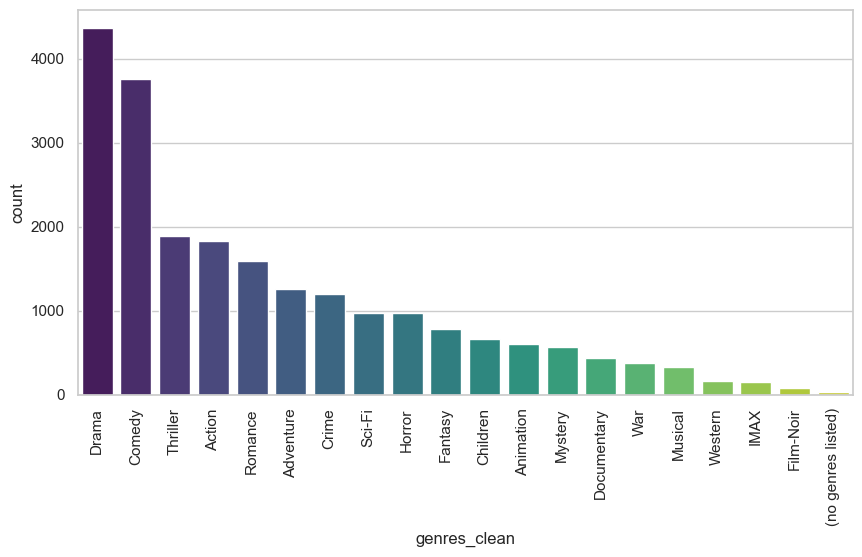

In [167]:
genres_counts_df = pd.DataFrame([genres_counts]).T.reset_index()
genres_counts_df.columns = ['genres_clean', 'count']
genres_counts_df = genres_counts_df.sort_values(by='count', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x='genres_clean', y='count', data=genres_counts_df, palette='viridis')
plt.xticks(rotation=90)
plt.show()

Now let's convert the year the movie was released into a variable.  
Notice how the title of the movies contains the year they were released:


In [168]:
movies.head()

,movieId,title,genres,genres_clean
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),Comedy,[Comedy]


### Analisis y creacion de la varaible year

In [169]:
import re 

def extract_year_from_title(title):
    t = title.split(' ')
    year = None
    if re.search(r'\(\d+\)', t[-1]):
        year = t[-1].strip('()')
        year = int(year)
    return year

In [170]:
movies['year'] = movies['title'].apply(extract_year_from_title)
movies.head()

,movieId,title,genres,genres_clean,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",1995.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",1995.0
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]",1995.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]",1995.0
4,5,Father of the Bride Part II (1995),Comedy,[Comedy],1995.0


In [171]:
print(f"The number of years is: {movies['year'].nunique()}")

The number of years is: 106


Let's look at the nulls

In [172]:
print(f"Movies after removing nulls {movies[~movies['year'].isnull()].shape}")

Movies after removing nulls (9718, 5)


In [173]:
movies.shape

(9742, 5)

We can remove them without altering our data too much.

In [174]:
movies = movies[~movies['year'].isnull()]

In [175]:
movies = movies[~movies['year'].isnull()]
print(f"Number of movies after removing null years: {movies['movieId'].nunique()}")

Number of movies after removing null years: 9718


Let's see the distribution

In [176]:
movies['year']

0       1995.0
1       1995.0
2       1995.0
3       1995.0
4       1995.0
         ...  
9737    2017.0
9738    2017.0
9739    2017.0
9740    2018.0
9741    1991.0
Name: year, Length: 9718, dtype: float64

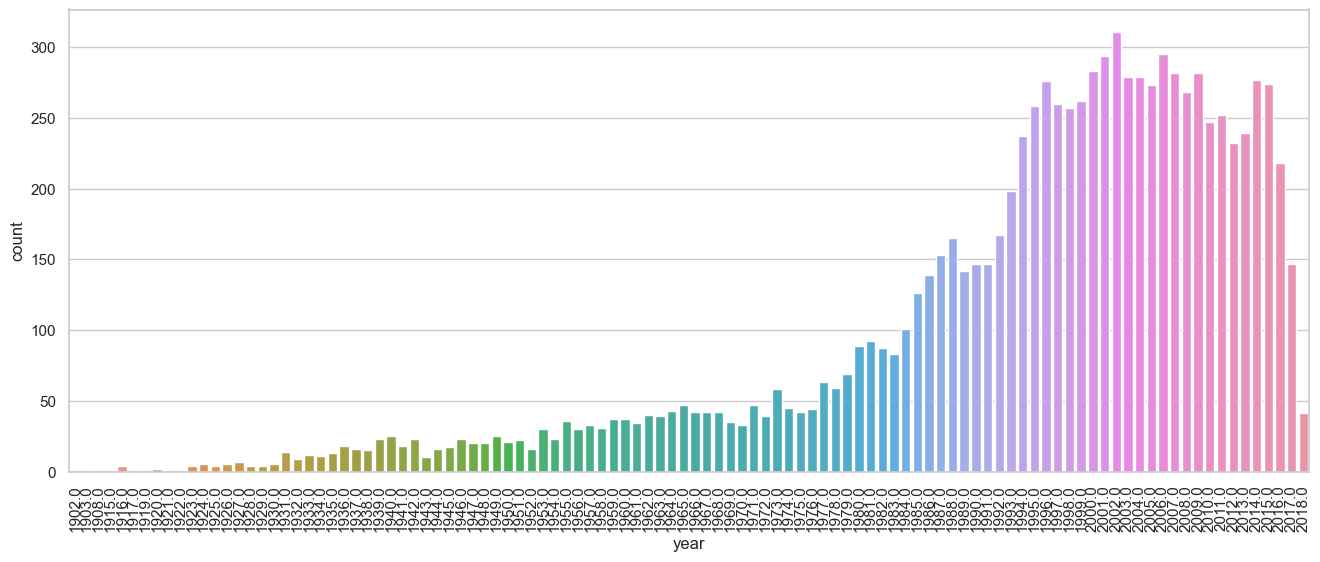

In [177]:
sns.countplot(x=movies['year'])
plt.xticks(rotation=90)
plt.show()

### Creation of the Decade variable

Podriamos utilizar directamente el año como varaible, pero proponemos usar las decadas.

In [178]:
def round_down(year):
    return year - (year%10)

movies['decade'] = movies['year'].apply(round_down)

In [179]:
movies.head(2)

,movieId,title,genres,genres_clean,year,decade
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",1995.0,1990.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",1995.0,1990.0


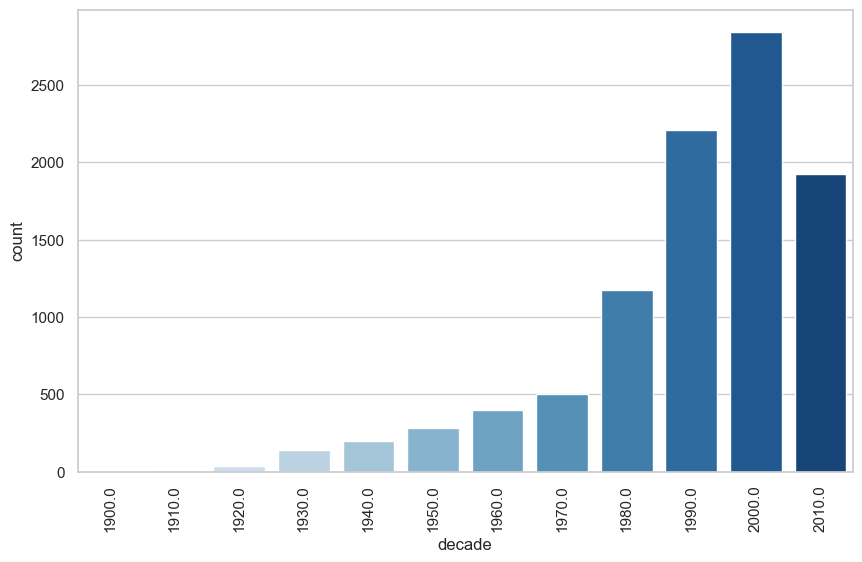

In [180]:
plt.figure(figsize=(10,6))
sns.countplot(x=movies['decade'], palette='Blues')
plt.xticks(rotation=90)
plt.show()

## Feature Engineering

Let's convert our gender variable to dummies

In [181]:
genres = list(genres_counts.keys())

for g in genres:
    movies[g] = movies['genres'].transform(lambda x: int(g in x))
movies[genres].head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [182]:
movies.head(2)

,movieId,title,genres,genres_clean,year,decade,Adventure,Animation,Children,Comedy,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",1995.0,1990.0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",1995.0,1990.0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Let's do the same with our decadal variable.

In [183]:
movie_decades = pd.get_dummies(movies['decade'])
movie_decades.head()

,1900.0,1910.0,1920.0,1930.0,1940.0,1950.0,1960.0,1970.0,1980.0,1990.0,2000.0,2010.0
0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0


Now let's create a new data set with our variables engineering

In [184]:
movie_features = pd.concat([movies[genres], movie_decades], axis=1)
movie_features.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,...,1920.0,1930.0,1940.0,1950.0,1960.0,1970.0,1980.0,1990.0,2000.0,2010.0
0,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Let's look at the distribution of genres per movie. For example, how many genres does each movie have?

In [185]:
movie_features[genres].sum(axis=1).describe()

count    9718.000000
mean        2.267442
std         1.123253
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        10.000000
dtype: float64

We observe that at most one movie has 10 genres, and most have less than three.  
**What would happen if the number of genres per movie were too high?**
Well, in this case our decade variable would be of little value, as its effect would be lost in the vastness of genres. The opposite happens with movies that have few genres. If we wanted to increase or weight the **decade** variable more, we would just multiply those columns by a certain value.

## Cold Start Model

We will use the `cosine` distance as in our previous model. [cosine distance](https://es.wikipedia.org/wiki/Similitud_coseno).

This distance compares the angle between two vectors in space, the larger the angle the greater the distance. Normalized by the size or dimension of the vectors.  
So an equivalent angle between both of 180 degrees the distance would be 1, while if their angle is equal to 0 the distance would be 0.

In [186]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_features, movie_features)
print(f"Dimension of our similarity matrix: {cosine_sim.shape}")

Dimension of our similarity matrix: (9718, 9718)


In [187]:
cosine_sim

array([[1.        , 0.81649658, 0.47140452, ..., 0.        , 0.23570226,
        0.57735027],
       [0.81649658, 1.        , 0.28867513, ..., 0.        , 0.        ,
        0.35355339],
       [0.47140452, 0.28867513, 1.        , ..., 0.        , 0.        ,
        0.81649658],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.40824829,
        0.        ],
       [0.23570226, 0.        , 0.        , ..., 0.40824829, 1.        ,
        0.        ],
       [0.57735027, 0.35355339, 0.81649658, ..., 0.        , 0.        ,
        1.        ]])

Now that we have our similarity matrix between movies, let's create our recommender with the help of the **fuzzywuzzy** package [paqueteria fuzzywuzzy](https://github.com/seatgeek/fuzzywuzzy).

The fuzzywuzzy package allows us to find similar strings, so we don't need to know the exact name of the movie, just an approximate one.

In [188]:
from fuzzywuzzy import process
def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

In [189]:
# Dictionary with the names of the movies
movie_idx = dict(zip(movies['title'], list(movies.index)))

In [190]:
movies.head(2)

,movieId,title,genres,genres_clean,year,decade,Adventure,Animation,Children,Comedy,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",1995.0,1990.0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",1995.0,1990.0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [191]:
for key, value in movie_idx.items():
    if value < 10:
        print(key, value)

Toy Story (1995) 0
Jumanji (1995) 1
Grumpier Old Men (1995) 2
Waiting to Exhale (1995) 3
Father of the Bride Part II (1995) 4
Heat (1995) 5
Sabrina (1995) 6
Tom and Huck (1995) 7
Sudden Death (1995) 8
GoldenEye (1995) 9


In [192]:
# Title of the movie
title = movie_finder('toy histry')
# Index
idx = movie_idx[title]

# Recommend
n_recommendations=10
# Scores of similarity for the movie we have selected
sim_scores = list(enumerate(cosine_sim[idx]))
# We order from highest to lowest similarity
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_movies = [i[0] for i in sim_scores]
print(f"Because you watched {title}:")
movies['title'].iloc[similar_movies]

Because you watched Toy Story (1995):


1706                                          Antz (1998)
2355                                   Toy Story 2 (1999)
559                                      Space Jam (1996)
1357                                Borrowers, The (1997)
1757                                 Bug's Life, A (1998)
2539                We're Back! A Dinosaur's Story (1993)
5624    Kirikou and the Sorceress (Kirikou et la sorci...
5975    Asterix & Obelix vs. Caesar (Astérix et Obélix...
6115                            Casper Meets Wendy (1998)
7759    Asterix in America (a.k.a Asterix Conquers Ame...
Name: title, dtype: object

Let's put the above into practice

In [193]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Recommendations for {title}:")
    print(movies['title'].iloc[similar_movies])

In [194]:
get_content_based_recommendations('aladin', 5)

Recommendations for Aladdin (1992):
1177                                      Hercules (1997)
95                          Muppet Treasure Island (1996)
673     Land Before Time III: The Time of the Great Gi...
1757                                 Bug's Life, A (1998)
3727                Ferngully: The Last Rainforest (1992)
Name: title, dtype: object


# Modeling with matrix factoring

Now we will learn how to build our recommender using matrix decomposition. This is very useful when we are handling very big data, imagine having 350 million users, 3 million artists, and 70 million songs...  
Given these characteristics it is advisable to reduce the dimensionality of our matrices, a kind of PCA.

Matrix decomposition can help us discover latent variables that explain our data. They can be interpreted as user tastes or preferences, although carrying out a punctual interpretation is a bit more difficult. Think of it more as an abstraction.

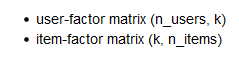

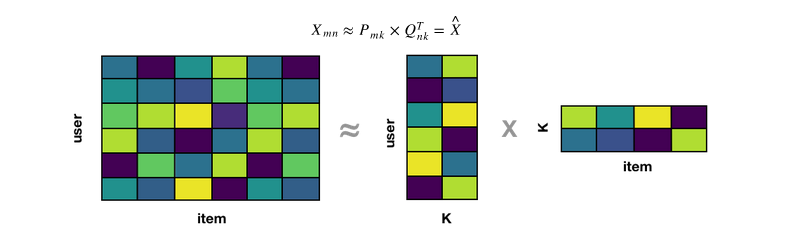

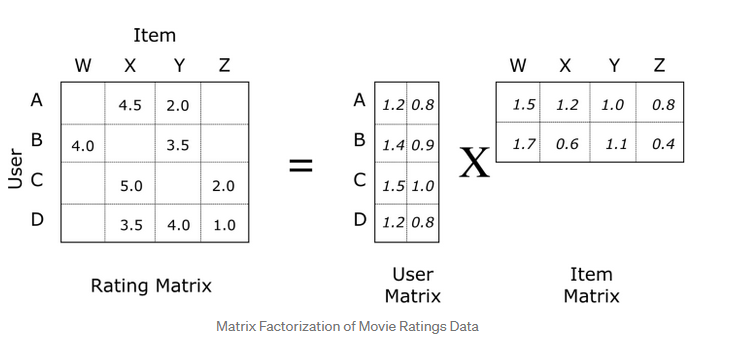

## SVD

We can make a first decomposition based on SVD, which is similar to PCA. The idea is the same as in our first item-item model, but instead of using the `X` matrix we will use a reduced dimension matrix through the SVD decomposition. 

In [195]:
from sklearn.decomposition import TruncatedSVD

# Let's factor our matrix
# The number of components can change
svd = TruncatedSVD(n_components=20, n_iter=10)
Z = svd.fit_transform(X)

# Example
movie_id = 1
similar_movies = find_similar_movies(movie_id, Z, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])



Because you watched Toy Story (1995):
Home Alone (1990)
Jurassic Park (1993)
Aladdin (1992)
Willy Wonka & the Chocolate Factory (1971)
Back to the Future (1985)
Forrest Gump (1994)
Groundhog Day (1993)
Star Wars: Episode IV - A New Hope (1977)
Princess Bride, The (1987)
Babe (1995)


## ALS (Alternating Least Squares)

Let's create some helper functions so that we are closer to a code that could be taken to production:

In [196]:
def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

movie_title_mapper = dict(zip(movies['title'], movies['movieId']))
movie_title_inv_mapper = dict(zip(movies['movieId'], movies['title']))

def get_movie_index(title):
    fuzzy_title = movie_finder(title)
    movie_id = movie_title_mapper[fuzzy_title]
    movie_idx = movie_mapper[movie_id]
    return movie_idx

def get_movie_title(movie_idx): 
    movie_id = movie_inv_mapper[movie_idx]
    title = movie_title_inv_mapper[movie_id]
    return title

The `ALS` method is computationally lighter than the SVD decomposition, so it tends to be widely used in production.

We will use the implicit package, with its method `AlternatingLeastSquares` [ALS](https://implicit.readthedocs.io/en/latest/als.html).  
This decomposition is intended for massive data so it also has its implementation in pySpark.

### Item-Item

In [197]:
model = implicit.als.AlternatingLeastSquares(factors=50)

**Note:** You may see a message like the one below when executing the above cell.

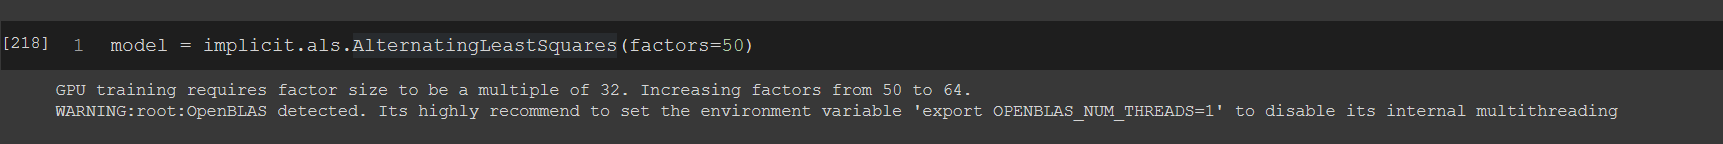

These style Warnings are of utmost importance. 
+ This is because the NVIDIA hardware and data structure comes in blocks of 32. By default **implicit** uses GPUs, so we must pass the parameter as false.
+ It is telling you to run the command `export OPENBLAS_NUM_THREADS=1` to avoid problems.  
What is happening is that this library uses the great, useful, and much loved scientific computing package known as [OpenBlas](https://www.openblas.net/) as a backend. This backend also parallelizes but it conflicts with the parallelization of the python package, so it would cause problems by saturating the number of parallel tasks that your process would ask to your computer, so it is necessary to set the OpenBlas parallelization to 1 thread, and let python handle it. Otherwise your code could take much longer to run.

[implicit.als.AlternatingLeastSquares](https://implicit.readthedocs.io/en/latest/als.html)

In [206]:
model = implicit.als.AlternatingLeastSquares(factors=50, use_gpu=False)

In [207]:
model.fit(X)

  0%|          | 0/15 [00:00<?, ?it/s]

In [208]:
movie_of_interest = 'forrest gump'
movie_index = get_movie_index(movie_of_interest)
related = model.similar_items(movie_index)
related


(array([314, 187,  28, 126, 308, 420, 284, 167,  26, 516]),
 array([1.0000001 , 0.617008  , 0.5690641 , 0.5140498 , 0.49884364,
        0.4960165 , 0.48932   , 0.4890729 , 0.4789022 , 0.4264316 ],
       dtype=float32))

This output is not very interpetable because we only see the indexes of the movies, so we can use the function we defined before known as `get_movie_title`.

In [209]:
related

(array([314, 187,  28, 126, 308, 420, 284, 167,  26, 516]),
 array([1.0000001 , 0.617008  , 0.5690641 , 0.5140498 , 0.49884364,
        0.4960165 , 0.48932   , 0.4890729 , 0.4789022 , 0.4264316 ],
       dtype=float32))

In [211]:
print(f"Because you watched Forest Gump {movie_finder(movie_of_interest)}...")
for r in related:
    recommended_title = get_movie_title(round(r[0]))
    if recommended_title != movie_finder(movie_of_interest):
        print(recommended_title)

Because you watched Forest Gump Forrest Gump (1994)...
Jumanji (1995)


### User-item

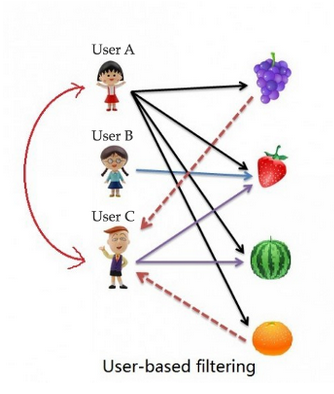

We will now make use of the recommendation functions found in the `implicit` package.

Let's take user 95

In [212]:
user_id = 95

In [213]:
user_ratings = ratings[ratings['userId']==user_id].merge(movies[['movieId', 'title']])
user_ratings = user_ratings.sort_values('rating', ascending=False)
print(f"Number of movies viewed by the user {user_id}: {user_ratings['movieId'].nunique()}")

Number of movies viewed by the user 95: 168


In [214]:
user_ratings

,userId,movieId,rating,timestamp,title
24,95,1089,5.0,1048382826,Reservoir Dogs (1992)
34,95,1221,5.0,1043340018,"Godfather: Part II, The (1974)"
83,95,3019,5.0,1043340112,Drugstore Cowboy (1989)
26,95,1175,5.0,1105400882,Delicatessen (1991)
27,95,1196,5.0,1043340018,Star Wars: Episode V - The Empire Strikes Back...
...,...,...,...,...,...
93,95,3690,2.0,1043339908,Porky's Revenge (1985)
122,95,5283,2.0,1043339957,National Lampoon's Van Wilder (2002)
100,95,4015,2.0,1043339957,"Dude, Where's My Car? (2000)"
164,95,7373,1.0,1105401093,Hellboy (2004)


Now let's take a look at your Top 5 and Bottom 5

In [215]:
user_ratings = ratings[ratings['userId']==user_id].merge(movies[['movieId', 'title']])
user_ratings = user_ratings.sort_values('rating', ascending=False)
top_5 = user_ratings.head()
top_5

,userId,movieId,rating,timestamp,title
24,95,1089,5.0,1048382826,Reservoir Dogs (1992)
34,95,1221,5.0,1043340018,"Godfather: Part II, The (1974)"
83,95,3019,5.0,1043340112,Drugstore Cowboy (1989)
26,95,1175,5.0,1105400882,Delicatessen (1991)
27,95,1196,5.0,1043340018,Star Wars: Episode V - The Empire Strikes Back...


In [216]:
bottom_5 = user_ratings[user_ratings['rating']<3].tail()
bottom_5

,userId,movieId,rating,timestamp,title
93,95,3690,2.0,1043339908,Porky's Revenge (1985)
122,95,5283,2.0,1043339957,National Lampoon's Van Wilder (2002)
100,95,4015,2.0,1043339957,"Dude, Where's My Car? (2000)"
164,95,7373,1.0,1105401093,Hellboy (2004)
109,95,4732,1.0,1043339283,Bubble Boy (2001)


Based on his preferences, we can infer that he likes crime and action movies, especially from the 90s. He has a certain distaste for comedies.  
Let's see what recommendations the `recommend` method of `implicit` gives.

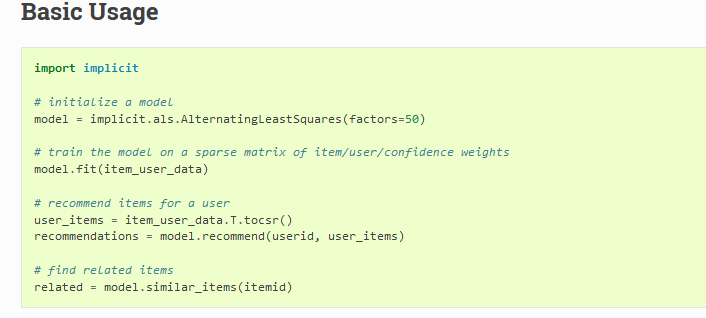

**We have to transpose the utility matrix, since it is now user-item**.  
So the matrix now corresponds to its canonical form: rows: users, cols: movie rating.

In [217]:
user_mapper[user_id]

94

In [222]:
user_id

95

In [ ]:
# We have to transpose the utility matrix, as it is now user-item
X_t = X.T.tocsr()

user_idx = user_mapper[user_id]
recommendations = model.recommend(user_idx, X_t)
recommendations

In [ ]:
for r in recommendations:
    recommended_title = get_movie_title(r[0])
    print(recommended_title)

In this case a user-item filter is easier to evaluate, because we can eliminate some ratings of our users, and see how good the model is at predicting it.

We could do it in python, but maybe just maybe it is convenient to do it in pySpark so we can extrapolate the code for when we have very large data.

# ALS Recommender System en Spark

## Install Spark

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.mirror.amaze.com.au/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
# In the following cell we will need the address where it is installed
# our version of spark
!ls /content/

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

import findspark
findspark.init()

In [228]:
from pyspark.sql.functions import col, explode
from pyspark import SparkContext

## Let's start Spark Session

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

sc = SparkSession \
        .builder \
        .appName("recommendation") \
        .getOrCreate()

## ETL

### Lectura de datos 

In [6]:
from pyspark import SparkFiles
# Let's add the address to our spark session
url = "https://raw.githubusercontent.com/IEXE-Tec/mcda-marketing/main/movies.csv"
sc.sparkContext.addFile(url)

# Let's read our file
movies = sc.read.csv("movies.csv",
                 header="true")

In [7]:
url = "https://raw.githubusercontent.com/IEXE-Tec/mcda-marketing/main/ratings.csv"
sc.sparkContext.addFile(url)

# Let's read our file
ratings = sc.read.csv("ratings.csv",
                 header="true")

In [8]:
ratings.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
|     1|    163|   5.0|964983650|
|     1|    216|   5.0|964981208|
|     1|    223|   3.0|964980985|
|     1|    231|   5.0|964981179|
|     1|    235|   4.0|964980908|
|     1|    260|   5.0|964981680|
|     1|    296|   3.0|964982967|
|     1|    316|   3.0|964982310|
|     1|    333|   5.0|964981179|
|     1|    349|   4.0|964982563|
+------+-------+------+---------+
only showing top 20 rows



In [10]:
ratings.printSchema()

root
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- timestamp: string (nullable = true)



In [11]:
movies.show()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

In [12]:
movies.printSchema()

root
 |-- movieId: string (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



### Handling of rating types

In [13]:
ratings = ratings.\
    withColumn('userId', col('userId').cast('integer')).\
    withColumn('movieId', col('movieId').cast('integer')).\
    withColumn('rating', col('rating').cast('float')).\
    drop('timestamp')
ratings.show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
|     1|     70|   3.0|
|     1|    101|   5.0|
|     1|    110|   4.0|
|     1|    151|   5.0|
|     1|    157|   5.0|
|     1|    163|   5.0|
|     1|    216|   5.0|
|     1|    223|   3.0|
|     1|    231|   5.0|
|     1|    235|   4.0|
|     1|    260|   5.0|
|     1|    296|   3.0|
|     1|    316|   3.0|
|     1|    333|   5.0|
|     1|    349|   4.0|
+------+-------+------+
only showing top 20 rows



## EDA

### Sparsity

In [14]:
# Let's count the number of observations in the dataset.
numerator = ratings.select("rating").count()

# Number of different ids
num_users = ratings.select("userId").distinct().count()
num_movies = ratings.select("movieId").distinct().count()

# Number of total cells
denominator = num_users * num_movies

# Sparsity
sparsity = (1.0 - (numerator *1.0)/denominator)*100
print(f"El sparcity de nuestros datos es {sparsity} % vacio")

El sparcity de nuestros datos es 98.30003169443864 % vacio


### Scanning of ids

In [15]:
# User ids
userId_ratings = ratings.groupBy("userId").count().orderBy('count', ascending=False)
userId_ratings.show()

+------+-----+
|userId|count|
+------+-----+
|   414| 2698|
|   599| 2478|
|   474| 2108|
|   448| 1864|
|   274| 1346|
|   610| 1302|
|    68| 1260|
|   380| 1218|
|   606| 1115|
|   288| 1055|
|   249| 1046|
|   387| 1027|
|   182|  977|
|   307|  975|
|   603|  943|
|   298|  939|
|   177|  904|
|   318|  879|
|   232|  862|
|   480|  836|
+------+-----+
only showing top 20 rows



In [16]:
# Movie ids
movieId_ratings = ratings.groupBy("movieId").count().orderBy('count', ascending=False)
movieId_ratings.show()

+-------+-----+
|movieId|count|
+-------+-----+
|    356|  329|
|    318|  317|
|    296|  307|
|    593|  279|
|   2571|  278|
|    260|  251|
|    480|  238|
|    110|  237|
|    589|  224|
|    527|  220|
|   2959|  218|
|      1|  215|
|   1196|  211|
|   2858|  204|
|     50|  204|
|     47|  203|
|    780|  202|
|    150|  201|
|   1198|  200|
|   4993|  198|
+-------+-----+
only showing top 20 rows



### Model ALS

In [17]:
# Spark functions for recommender
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [18]:
# Let's separate Train and Test
(train, test) = ratings.randomSplit([0.8, 0.2], seed = 1234)
# We create the ALS model
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",
          nonnegative = True, implicitPrefs = False, coldStartStrategy="drop")

In [19]:
# Let's do a grid search of our parameters
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [10, 50]) \
            .addGrid(als.regParam, [.01, .05]) \
            .build()
           
# Definir el evaluador como RMSE e imprimir la longitud del evaluador
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction") 
print ("Numero de modelos que estimaremos: ", len(param_grid))

Numero de modelos que estimaremos:  4


#### CV Pipeline

In [20]:
# Pipeline for CV
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

#### Training

In [21]:
# train
model = cv.fit(train)

# Let´s take the best model
best_model = model.bestModel

Analysis of the best model

In [22]:
print(type(best_model))
print("**El mejor modelo**")
print("  Rank:", best_model._java_obj.parent().getRank())
print("  MaxIter:", best_model._java_obj.parent().getMaxIter())
print("  RegParam:", best_model._java_obj.parent().getRegParam())

<class 'pyspark.ml.recommendation.ALSModel'>
**El mejor modelo**
  Rank: 10
  MaxIter: 10
  RegParam: 0.05


In [23]:
# Let's evaluate the predictions
test_predictions = best_model.transform(test)
RMSE = evaluator.evaluate(test_predictions)
print(RMSE)

0.9205925845454961


In [24]:
test_predictions.show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   148|    356|   4.0|  3.249162|
|   148|   4896|   4.0| 3.7603178|
|   148|   4993|   3.0| 3.4813557|
|   148|   7153|   3.0|  3.173752|
|   148|   8368|   4.0| 3.8109899|
|   148|  40629|   5.0|  3.857356|
|   148|  50872|   3.0| 3.4428864|
|   148|  60069|   4.5| 3.7751334|
|   148|  69757|   3.5| 3.1637132|
|   148|  72998|   4.0|  2.751464|
|   148|  81847|   4.5| 3.8940604|
|   148|  98491|   5.0| 3.9980886|
|   148| 115617|   3.5|  4.697919|
|   148| 122886|   3.5| 3.4836917|
|   463|    296|   4.0| 4.5110555|
|   463|    527|   4.0| 4.2326927|
|   463|   2019|   4.0| 3.8669696|
|   471|    527|   4.5| 3.1969426|
|   471|   6016|   4.0| 3.5889056|
|   471|   6333|   2.5| 2.9515104|
+------+-------+------+----------+
only showing top 20 rows



### Generate Recommendations

In [25]:
# Generate n recommendations
nrecommendations = best_model.recommendForAllUsers(10)
nrecommendations.limit(10).show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|     1|[{4617, 5.9099364...|
|     3|[{5480, 5.780541}...|
|     5|[{86320, 5.206465...|
|     6|[{86320, 6.676039...|
|     9|[{89904, 6.117831...|
|    12|[{446, 7.410233},...|
|    13|[{127108, 5.95200...|
|    15|[{27611, 5.818577...|
|    16|[{446, 4.5170155}...|
|    17|[{177593, 5.28059...|
+------+--------------------+



In [26]:
nrecommendations = nrecommendations\
    .withColumn("rec_exp", explode("recommendations"))\
    .select('userId', col("rec_exp.movieId"), col("rec_exp.rating"))

nrecommendations.limit(10).show()

+------+-------+---------+
|userId|movieId|   rating|
+------+-------+---------+
|     1|   4617|5.9099364|
|     1|   3153|5.6937804|
|     1|   7034|5.6819506|
|     1|   3606|5.6499534|
|     1|   3201| 5.619744|
|     1| 112421|5.6027107|
|     1|   3836|5.5866556|
|     1| 170705|5.5794063|
|     1|   2019| 5.572904|
|     1| 127108|5.5602045|
+------+-------+---------+



#### Intuition of the Recommendations

In [27]:
nrecommendations.join(movies, on='movieId').filter('userId = 100').show()

+-------+------+---------+--------------------+--------------------+
|movieId|userId|   rating|               title|              genres|
+-------+------+---------+--------------------+--------------------+
|   6380|   100|5.5934753|Capturing the Fri...|         Documentary|
|   7121|   100|5.4971795|   Adam's Rib (1949)|      Comedy|Romance|
|   3837|   100|5.4963293|  Phantasm II (1988)|Action|Fantasy|Ho...|
|    446|   100|5.4474974|Farewell My Concu...|       Drama|Romance|
|  98279|   100| 5.374304|Fantastic Fear of...|              Comedy|
|    222|   100| 5.350547|Circle of Friends...|       Drama|Romance|
|   5014|   100|5.3104177|     I Am Sam (2001)|               Drama|
|    945|   100| 5.308489|      Top Hat (1935)|Comedy|Musical|Ro...|
|   3404|   100|5.3043027|      Titanic (1953)|        Action|Drama|
|   7981|   100| 5.279101|Infernal Affairs ...|Crime|Drama|Thriller|
+-------+------+---------+--------------------+--------------------+



In [28]:
ratings.join(movies, on='movieId').filter('userId = 100').sort('rating', ascending=False).limit(10).show()

+-------+------+------+--------------------+--------------------+
|movieId|userId|rating|               title|              genres|
+-------+------+------+--------------------+--------------------+
|   1101|   100|   5.0|      Top Gun (1986)|      Action|Romance|
|   1958|   100|   5.0|Terms of Endearme...|        Comedy|Drama|
|   2423|   100|   5.0|Christmas Vacatio...|              Comedy|
|   4041|   100|   5.0|Officer and a Gen...|       Drama|Romance|
|   5620|   100|   5.0|Sweet Home Alabam...|      Comedy|Romance|
|    368|   100|   4.5|     Maverick (1994)|Adventure|Comedy|...|
|    934|   100|   4.5|Father of the Bri...|              Comedy|
|    539|   100|   4.5|Sleepless in Seat...|Comedy|Drama|Romance|
|     16|   100|   4.5|       Casino (1995)|         Crime|Drama|
|    553|   100|   4.5|    Tombstone (1993)|Action|Drama|Western|
+-------+------+------+--------------------+--------------------+

